In [55]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
from scipy import stats
import seaborn as sns; sns.set()

# Potential function

See `hmc_temp.py`

# Import data

In [56]:
# Choose dataset
dataset = "synthetic" # "synthetic" , "retail", "commuter_ward", "commuter_borough"
# Define possible alphas
alphas = [0.5,1.0,1.5,2.0]
# Optimal alpha
alpha = 2.0 # 1.14
# Select model ('singly' or 'doubly')
constrained = 'singly'

# Select burn in (in terms of number of iterations)
burnin = 0

In [57]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
# final_destination_sizes = np.loadtxt(f'../data/input/{dataset}/final_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')
destinations = np.loadtxt(f'../data/input/{dataset}/destinations.txt',dtype='str',delimiter='\n')

# Store dimensions
N,M = cost_matrix.shape

# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# xf = np.log(final_destination_sizes/np.sum(final_destination_sizes))
# Define normalised cost_matrix
c = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
o = origin_supply/np.sum(origin_supply)

# Run HMC

Cose is saved in `hmc_temp.py`

# Visualise posterior samples

In [58]:
# Import HMC data
samples = np.loadtxt(f"../data/output/{dataset}/inverse_problem/{constrained}_hmc_samples_{alpha}.txt")

# Select dimension of samples to visualise 
dim = 0

assert dim >= 0 and dim <= samples.shape[1]

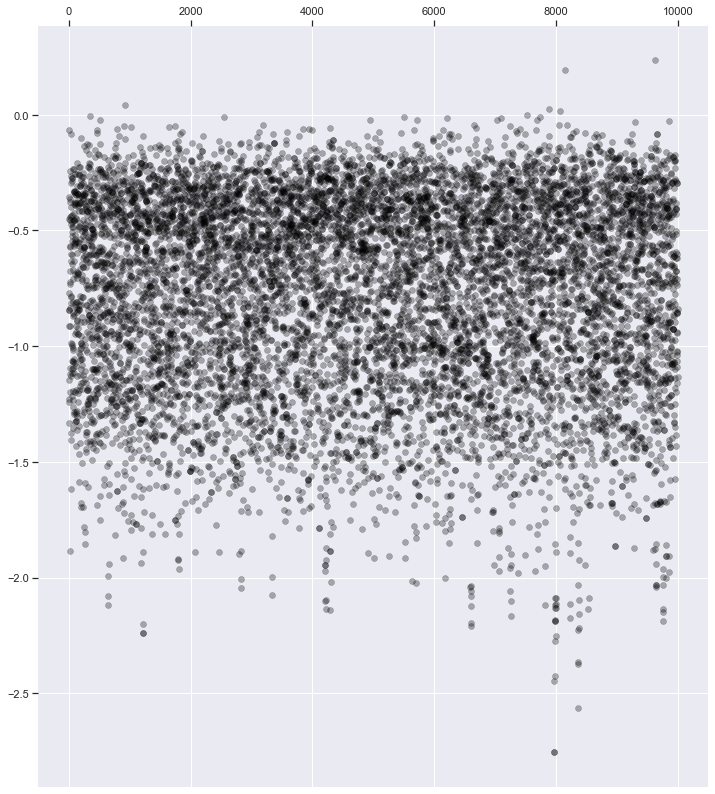

In [59]:
# Plot samples
plt.figure(figsize=(12, 14)) 

ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_top()    
ax.get_yaxis().tick_left()    
  
plt.scatter(range(burnin,samples.shape[0]), samples[burnin:samples.shape[0],dim], lw=0.5, color="black", alpha=0.3)    

plt.show()

In [60]:
# Compute discrepancy between actual and estimated latents
estimated_sizes = np.mean(samples[burnin:samples.shape[0],:],axis=0)

In [61]:
np.exp(estimated_sizes)

array([0.46297258, 0.45781137])

In [62]:
np.exp(xd)

array([0.33333333, 0.66666667])

In [70]:
(np.exp(estimated_sizes)-np.exp(xd))/np.exp(xd)

array([ 0.38891775, -0.31328294])

## Posterior sample scatter plot

In [63]:
# Select dimensions to plot
dim1 = np.random.randint(0,M)
dim2 = np.random.randint(0,M)
while dim2 == dim1:
    dim2 = np.random.randint(0,M)
log_view = True
print('Destination i',destinations[dim1],'Destination j',destinations[dim2])

Destination i central_cam Destination j west_cam


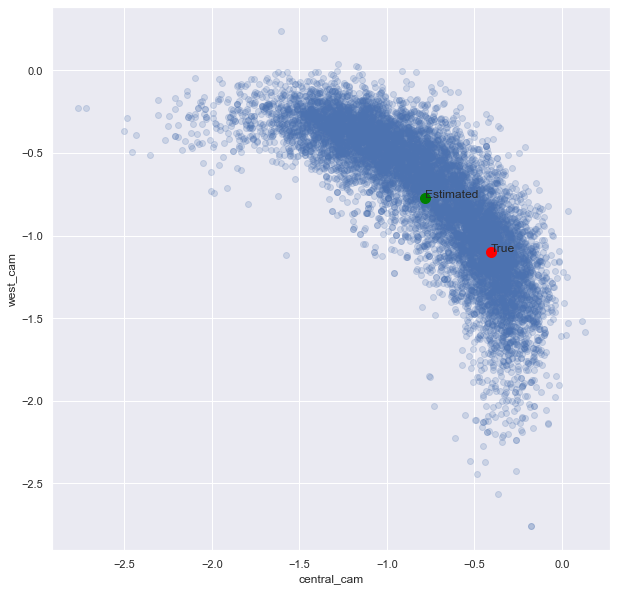

In [64]:
if log_view:
    plt.figure(figsize=(10,10))
    plt.scatter(samples[burnin:samples.shape[0],dim1],samples[burnin:samples.shape[0],dim2],alpha=0.2)
    plt.scatter(xd[dim1],xd[dim2],color='red',s=100)
    plt.scatter(estimated_sizes[dim1],estimated_sizes[dim2],color='green',s=100)
    plt.xlabel(destinations[dim1])
    plt.ylabel(destinations[dim2])
    plt.annotate(s='True',xy=(xd[dim1],xd[dim2]))
    plt.annotate(s='Estimated',xy=(estimated_sizes[dim1],estimated_sizes[dim2]))
    # plt.xlim([np.min(np.exp(samples[burnin:samples.shape[0],dim1]))*(4/5), np.max(np.exp(samples[burnin:samples.shape[0],dim1]))*0.02])
    # plt.ylim([np.min(np.exp(samples[burnin:samples.shape[0],dim2]))*(4/5), np.max(np.exp(samples[burnin:samples.shape[0],2]))*0.02])
else:
    plt.figure(figsize=(10,10))
    plt.scatter(np.exp(samples[burnin:samples.shape[0],dim1]),np.exp(samples[burnin:samples.shape[0],dim2]),alpha=0.2)
    plt.scatter(np.exp(xd[dim1]),np.exp(xd[dim2]),color='red',s=100)
    plt.scatter(np.exp(estimated_sizes[dim1]),np.exp(estimated_sizes[dim2]),color='green',s=100)
    plt.xlabel(destinations[dim1])
    plt.ylabel(destinations[dim2])
    plt.annotate(s='True',xy=(np.exp(xd[dim1]),np.exp(xd[dim2])))
    plt.annotate(s='Estimated',xy=(np.exp(estimated_sizes[dim1]),np.exp(estimated_sizes[dim2])))
    # plt.xlim([np.min(np.exp(samples[burnin:samples.shape[0],dim1]))*(4/5), np.max(np.exp(samples[burnin:samples.shape[0],dim1]))*0.02])
    # plt.ylim([np.min(np.exp(samples[burnin:samples.shape[0],dim2]))*(4/5), np.max(np.exp(samples[burnin:samples.shape[0],2]))*0.02])

### Sample from a Normal centered around destination demands

In [65]:
if constrained == 'doubly':
    # Import destination demand
    dest_demand = np.loadtxt(f"../data/input/{dataset}/destination_demand.txt")

    # Sample from normal
    baseline_latent_samples = np.random.multivariate_normal(dest_demand[:,0], 0.2*np.identity(dest_demand[:,0].shape[0]), 10000)
    baseline_latents = np.sum(baseline_latent_samples,axis=0)

    # Normalise and take logs
    baseline_latents = np.log(baseline_latents/np.sum(baseline_latents))
    
    print('Naive baseline destination sizes sampled from a Normal centered around destination demand - log normalised')
    baseline_latents

In [66]:
print('HMC sampled latent destination sizes - log normalised')
print(np.exp(estimated_sizes))
print('Estimated total size')
print(np.sum(np.exp(estimated_sizes)))

HMC sampled latent destination sizes - log normalised
[0.46297258 0.45781137]
Estimated total size
0.9207839536087722


In [67]:
print('Actual initial destination sizes log normalised')
print(np.exp(xd))
print('Actual total size')
print(np.sum(np.exp(xd)))

Actual initial destination sizes log normalised
[0.33333333 0.66666667]
Actual total size
1.0


In [68]:
print("Ratio of HMC sampled latent sizes to actual sizes")
estimated_sizes/(xd)

Ratio of HMC sampled latent sizes to actual sizes


array([0.7009638 , 1.92691805])

In [69]:
np.mean((np.exp(estimated_sizes)-np.exp(xd))/np.exp(xd))

0.037817402747550105

In [25]:
if constrained == 'doubly':
    print("Ratio of baseline destination sizes to actual destination sizes")
    print(baseline_latents/xd)